# Toy models of transient warming

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

## Exploring the rate of climate change

In the last set of notes and homework we discussed differences between **equilibrium warming** and **transient warming** due to the slowly-evolving effects of ocean heat uptake.

Here we are going to look at some toy climate models and think about relationships between climate sensitivity, ocean heat uptake, and timescales.

## Two versions of Radiative-Convective Equilibrium with different climate sensitivities

We are going set up two different single-column model with different lapse rate feedbacks.

We begin by repeating the same setup we have done several times before, building a single-column RCM with prescribed water vapor profile.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab

In [2]:
# Get the water vapor data from CESM output
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))

In [3]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
steps_per_year = 90
deltat = climlab.constants.seconds_per_year/steps_per_year
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = deltat,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,)
rcm_control = climlab.couple([rad,conv], name='Radiative-Convective Model')

Integrate the control model out to equilibrium.

In [4]:
rcm_control.integrate_years(5)
rcm_control.ASR - rcm_control.OLR

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


Field([-5.7127636e-12])

Now let's make two copies of this model and keep them in a list:

In [5]:
slab_control = []
slab_control.append(rcm_control)
slab_control.append(climlab.process_like(rcm_control))

We are going to **double CO2 in both models** and label them as high and low sensitivity. We will build in **different feedbacks** into our two columns.

In [6]:
slab_2x = []
for n in range(len(slab_control)):
    rcm_2xCO2 = climlab.process_like(rcm_control)
    rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
    if n == 0:
        rcm_2xCO2.name = 'High-sensitivity RCM'
    elif n == 1:
        rcm_2xCO2.name = 'Low-sensitivity RCM'
    slab_2x.append(rcm_2xCO2)

We will implement a water vapor feedback as we have done before: by recomputing the specific humidity at every timestep using the current temperatures so that the **relative humidity stays fixed**.

We begin by computing the relative humidity profile from the control climate.

In [7]:
#  actual specific humidity
q = rcm_control.subprocess['Radiation'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm_control.Tatm, rcm_control.lev)
#  Relative humidity
rh = q/qsat

Now here is where our two models will differ:

We are going to assign them **different lapse rate feedbacks**.

Similar to the exercise in [this homework assignment](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/assignment-rcm-feedback.html), we are going to assume 

$$ \Gamma = \Gamma_{ref} + \gamma * \Delta T_s $$

where $\Gamma_{ref} = 6.5 K/km$ is the critical lapse rate in our control climate, and $\gamma$ is a number in units of km$^{-1}$ that determines how much the critical lapse rate should change per degree warming.

We are going to investigate two different assumptions:

- temperatures decrease **more** with height under global warming, $\gamma = +0.3$ km$^{-1}$
- temperature decrease **less** with height under global warming, $\gamma = -0.3$ km$^{-1}$

In [8]:
lapse_change_factor = [+0.3, -0.3]

In [9]:
for n in range(len(slab_2x)):
    rcm_2xCO2 = slab_2x[n]
    print('Integrating ' + rcm_2xCO2.name)
    for m in range(5 * steps_per_year):
        # At every timestep
        # we calculate the new saturation specific humidity for the new temperature
        #  and change the water vapor in the radiation model
        #  so that relative humidity is always the same
        qsat = climlab.utils.thermo.qsat(rcm_2xCO2.Tatm, rcm_2xCO2.lev)
        rcm_2xCO2.subprocess['Radiation'].specific_humidity[:] = rh * qsat
        #  We also adjust the critical lapse rate in our convection model
        DeltaTs = rcm_2xCO2.Ts - rcm_control.Ts
        rcm_2xCO2.subprocess['Convection'].adj_lapse_rate = 6.5 + lapse_change_factor[n]*DeltaTs
        rcm_2xCO2.step_forward()
    print('The TOA imbalance is %0.5f W/m2' %(rcm_2xCO2.ASR-rcm_2xCO2.OLR))
    print('The ECS is %0.3f K' %(rcm_2xCO2.Ts - rcm_control.Ts))
    print('')

Integrating High-sensitivity RCM
The TOA imbalance is 0.00003 W/m2
The ECS is 3.566 K

Integrating Low-sensitivity RCM
The TOA imbalance is 0.00022 W/m2
The ECS is 2.216 K



So Model 0 (in which the lapse rates have gotten larger) is **more sensitive** than Model 1 (smaller lapse rates). It has a larger system gain, or a more positive overall climate feedback. 

Although this is not the main topic of today's lesson, it's still interesting to think about why the lapse rates affect the climate sensivitity in this way...

## Time to reach equilibrium

These models reached their new equilibria in just a few years. Why is that? Because they have very little heat capacity:

In [10]:
slab_control[0].depth_bounds

array([0. , 2.5])

The "ocean" in these models is just a "slab" of water 2.5 meter deep.

That's all we need to calculate the equilibrium temperatures, but it tells us nothing about the timescales for climate change in the real world.

For this, we need a deep ocean that can **exchange heat with the surface**.

## Transient warming scenarios in column models with ocean heat uptake

We are now going to build two new models. The atmosphere (radiative-convective model) will be identical to the two "slab" models we just used. But these will be coupled to a **column of ocean water** 2000 m deep!

We will **parameterize the ocean heat uptake** as a diffusive mixing process. Much like when we discussed the diffusive parameterization for atmospheric heat transport -- we are assuming that ocean dynamics result in a vertical mixing of heat from warm to cold temperatures.

The following code will set this up for us.

We will make one more assumption, just for the sake of illustration:

*The more sensitive model (Model 0) is also more efficent at taking up heat into the deep ocean*

In [11]:
#  Create the domains
ocean_bounds = np.arange(0., 2010., 100.)
depthax = climlab.Axis(axis_type='depth', bounds=ocean_bounds)
ocean = climlab.domain.domain.Ocean(axes=depthax)
atm = slab_control[0].Tatm.domain

#  Model 0 has a higher ocean heat diffusion coefficient -- 
#  a more efficent deep ocean heat sink
ocean_diff = [5.E-4, 3.5E-4]

#  List of deep ocean models
deep = []
for n in range(len(slab_control)):
    rcm_control = slab_control[n]
    #  Create the state variables
    Tinitial_ocean = rcm_control.Ts * np.ones(ocean.shape)
    Tocean = climlab.Field(Tinitial_ocean.copy(), domain=ocean)
    Tatm = climlab.Field(rcm_control.Tatm.copy(), domain=atm)

    #  Surface temperature Ts is the upper-most grid box of the ocean
    Ts = Tocean[0:1]
    atm_state = {'Tatm': Tatm, 'Ts': Ts}
    
    rad = climlab.radiation.RRTMG(name='Radiation',
                                  state=atm_state, 
                                  specific_humidity=Qglobal.values,
                                  timestep = deltat,
                                  albedo = 0.25,  
                                 )
    conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                                   state=atm_state,
                                                   adj_lapse_rate=6.5,
                                                   timestep=rad.timestep,)

    model = rad + conv
    if n == 0:
        model.name = 'RCM with high sensitivity and efficient heat uptake'
    elif n == 1:
        model.name = 'RCM with low sensitivity and inefficient heat uptake'
    model.set_state('Tocean', Tocean)
    diff = climlab.dynamics.Diffusion(state={'Tocean': model.Tocean}, 
                                K=ocean_diff[n], 
                                diffusion_axis='depth', 
                                timestep=deltat * 10,)
    model.add_subprocess('Ocean Heat Uptake', diff)
    print('')
    print(model)
    print('')
    deep.append(model)


climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
  Tocean: (20,) 
The subprocess tree: 
RCM with high sensitivity and efficient heat uptake: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Ocean Heat Uptake: <class 'climlab.dynamics.advection_diffusion.Diffusion'>



climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
  Tocean: (20,) 
The subprocess tree: 
RCM with low sensitivity and inefficient heat uptake: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class

## An idealized transient global warming scenario: CO2 increases by 1%/year to doubling.

Now consider the CO2 increase. In the real world, CO2 has been increasing every year since the beginning of industrialization. Future CO2 concentrations depend on collective choices made by human societies about how much fossil fuel to extract and burn.

We will set up a simple scenario. Suppose that CO2 increases by 1% of its existing concentration every year **until it reaches 2x its initial concentration**. This takes about 70 years.

After 70 years, we assume that all anthropogenic emissions, and CO2 concentration is **stabilized** at the 2x level.

What happens to the surface temperature?

How do the histories of surface and deep ocean temperature compare in our two models?

We are going to simulation **400 years of transient global warming** in the two models.

<div class="alert alert-success">
This code will take a long time to run! While it's running, we'll think about what the result might look like
</div>

In [12]:
num_years = 400
years = np.arange(num_years+1)

Tsarray = []
Tocean = []
netrad = []
for n in range(len(deep)):
    thisTs = np.nan * np.zeros(num_years+1)
    thisnetrad = np.nan * np.zeros(num_years+1)
    thisTocean = np.nan * np.zeros((deep[n].Tocean.size, num_years+1))
    thisTs[0] = deep[n].Ts
    thisnetrad[0] = deep[n].ASR - deep[n].OLR
    thisTocean[:, 0] = deep[n].Tocean
    Tsarray.append(thisTs)
    Tocean.append(thisTocean)
    netrad.append(thisnetrad)
    
CO2initial = deep[0].subprocess['Radiation'].absorber_vmr['CO2']
CO2array = np.nan * np.zeros(num_years+1)
CO2array[0] = CO2initial * 1E6

#  Increase CO2 by 1% / year for 70 years (until doubled), and then hold constant
for y in range(num_years):
    if deep[0].subprocess['Radiation'].absorber_vmr['CO2'] < 2 * CO2initial:
        for model in deep:
            model.subprocess['Radiation'].absorber_vmr['CO2'] *= 1.01
    CO2array[y+1] = deep[0].subprocess['Radiation'].absorber_vmr['CO2'] * 1E6
    print('Year ', y+1, ', CO2 mixing ratio is ', CO2array[y+1],' ppm.')

    for n, model in enumerate(deep):
        for m in range(steps_per_year):            
            qsat = climlab.utils.thermo.qsat(model.Tatm, model.lev)
            model.subprocess['Radiation'].specific_humidity[:] = rh * qsat
            DeltaTs = model.Ts - slab_control[n].Ts
            model.subprocess['Convection'].adj_lapse_rate = 6.5 + lapse_change_factor[n]*DeltaTs
            model.step_forward()
            
            Tsarray[n][y+1] = model.Ts
            Tocean[n][:, y+1] = model.Tocean
            netrad[n][y+1] = model.ASR - model.OLR

Year  1 , CO2 mixing ratio is  351.47999999999996  ppm.
Year  2 , CO2 mixing ratio is  354.9948  ppm.
Year  3 , CO2 mixing ratio is  358.54474799999997  ppm.
Year  4 , CO2 mixing ratio is  362.13019548  ppm.
Year  5 , CO2 mixing ratio is  365.7514974348  ppm.
Year  6 , CO2 mixing ratio is  369.409012409148  ppm.
Year  7 , CO2 mixing ratio is  373.1031025332395  ppm.
Year  8 , CO2 mixing ratio is  376.8341335585719  ppm.
Year  9 , CO2 mixing ratio is  380.60247489415764  ppm.
Year  10 , CO2 mixing ratio is  384.4084996430992  ppm.
Year  11 , CO2 mixing ratio is  388.2525846395302  ppm.
Year  12 , CO2 mixing ratio is  392.1351104859255  ppm.
Year  13 , CO2 mixing ratio is  396.0564615907848  ppm.
Year  14 , CO2 mixing ratio is  400.01702620669266  ppm.
Year  15 , CO2 mixing ratio is  404.01719646875955  ppm.
Year  16 , CO2 mixing ratio is  408.05736843344715  ppm.
Year  17 , CO2 mixing ratio is  412.1379421177816  ppm.
Year  18 , CO2 mixing ratio is  416.2593215389594  ppm.
Year  19 , CO

Year  147 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  148 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  149 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  150 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  151 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  152 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  153 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  154 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  155 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  156 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  157 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  158 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  159 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  160 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  161 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  162 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  163 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  164 , CO2 mixing ratio is

Year  291 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  292 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  293 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  294 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  295 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  296 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  297 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  298 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  299 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  300 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  301 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  302 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  303 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  304 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  305 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  306 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  307 , CO2 mixing ratio is  698.3536522015938  ppm.
Year  308 , CO2 mixing ratio is

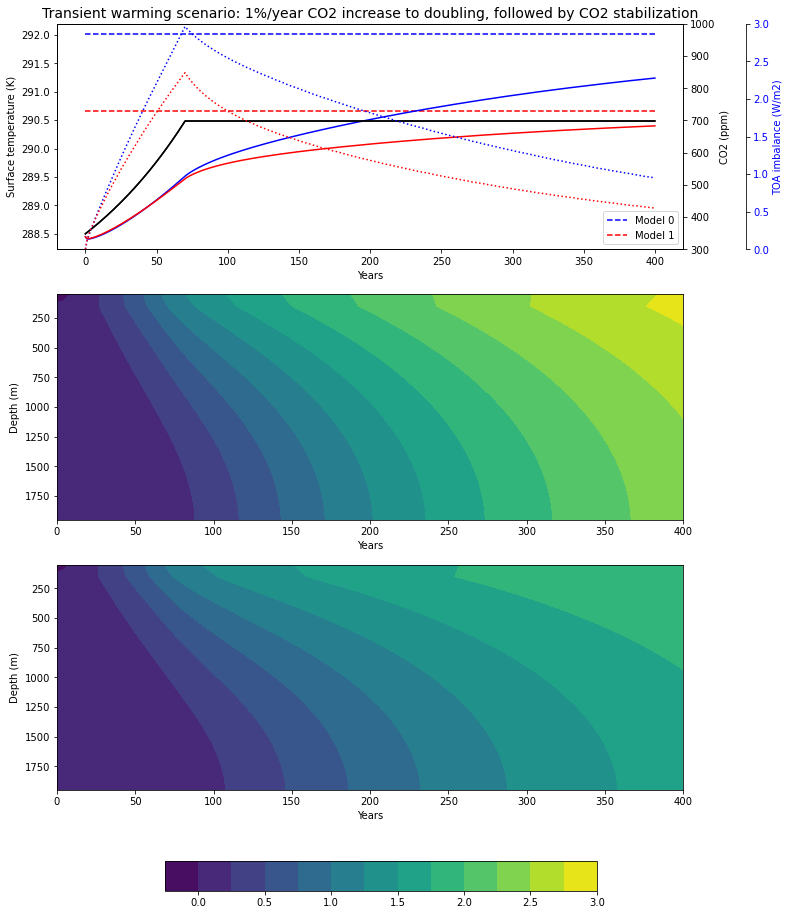

In [13]:
colorlist = ['b', 'r']
co2color = 'k'

num_axes = len(deep) + 1
fig, ax = plt.subplots(num_axes, figsize=(12,14))

# Twin the x-axis twice to make independent y-axes.
topaxes = [ax[0], ax[0].twinx(), ax[0].twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.85)

# Move the last y-axis spine over to the right by 10% of the width of the axes
topaxes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
topaxes[-1].set_frame_on(True)
topaxes[-1].patch.set_visible(False)

for n, model in enumerate(slab_2x):
    topaxes[0].plot(model.Ts*np.ones_like(Tsarray[n]), '--', color=colorlist[n])
topaxes[0].set_ylabel('Surface temperature (K)')
topaxes[0].set_xlabel('Years')
topaxes[0].set_title('Transient warming scenario: 1%/year CO2 increase to doubling, followed by CO2 stabilization', fontsize=14)
topaxes[0].legend(['Model 0', 'Model 1'], loc='lower right')

topaxes[1].plot(CO2array, color=co2color)
topaxes[1].set_ylabel('CO2 (ppm)', color=co2color)
for tl in topaxes[1].get_yticklabels():
    tl.set_color(co2color)
topaxes[1].set_ylim(300., 1000.)

topaxes[2].set_ylabel('TOA imbalance (W/m2)', color='b')
for tl in topaxes[2].get_yticklabels():
    tl.set_color('b')
topaxes[2].set_ylim(0, 3)


contour_levels = np.arange(-0.25, 3.25, 0.25)
for n in range(len(deep)):
    cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)
    ax[n+1].invert_yaxis()
    ax[n+1].set_ylabel('Depth (m)')
    ax[n+1].set_xlabel('Years')


for n, model in enumerate(deep):
    topaxes[0].plot(Tsarray[n], color=colorlist[n])
    topaxes[2].plot(netrad[n], ':', color=colorlist[n])
    for n in range(len(deep)):
        cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)    
topaxes[1].plot(CO2array, color=co2color)

fig.subplots_adjust(bottom=0.12)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal');

## Transient vs. equilibrium warming: key points

- During the first 70 years, the radiative forcing goes up every year
- The warming in the two models is almost identical during this phase
- After year 70, the CO2 levels are stable and so the radiative forcing is no longer increasing
- Both models continue to warm for hundreds of years
- The difference between the two models become larger over time
- In either case, at the time of CO2 doubling the model has achieved only a fraction of its equilibrium surface warming.
- The difference between the warming at year 70 and the equilibrium warming is called the **committed warming**. It is the global warming associated with CO2 emissions that are **already in the atmosphere**.
- How do we know at year 70 what the committed warming is?  Are we on the blue or the red path? At year 70, have we achieved half or only a third of the eventual equilibrium warming?
- In our example, the more sensitive model also has more efficient ocean heat uptake, so the initial warming looks identical. 
- **Uncertainties in both climate feedback processes and ocean heat uptake processes contribute to uncertainty in the rate of global warming**

## Results from comprehensive coupled GCMs

### Fast and slow components of the warming

This figure shows how a comprehensive coupled GCM responds to the same kind of idealized CO2 increase we have looked at above: CO2 increases at 1%/year for 70 years and is then held constant at twice the pre-industrial level (blue curve), or at 4x the pre-industrial level (red curve).

The dashed curve show the **ocean heat content** continuing to rise slowly over thousands of years.

<img src="http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/Yoshimori_transientwarming.png" width="400">

> M. Yoshimori, M. Watanabe, H. Shiogama, A. Oka, A. Abe-Ouchi, R. Ohgaito, and Y. Kamae. A review of progress towards understanding the transient global mean surface temperature response to radiative perturbation. Prog. Earth Planet. Sic., 3, 2016.

### What happens if CO2 levels are abruptly returned to pre-industrial levels? 

Here, in a different model, we see the surface temperature change through the historical period (black) followed by a typical future global warming scenario (blue).

The red curves show the effects of suddenly returning greenhouse gases to their preindustrial levels at various times in the future.

The temperatures very quickly drop, but **not back to the preindustrial values**. Over time, the build-up of heat content in the deep ocean means that, even if CO2 levels revert to what they used to be, the climate remain quite a bit warmer for thousands of years.

This has been referred to as the **recalcitrant** component of global warming, in analogy with stubborn medical conditions that are difficult to treat.

<img src="http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/Held_recalcitrant.png" width="400">

> I. M. Held, M. Winton, K. Takahashi, T. Delworth, F. Zeng, and G. K. Vallis. Probing the fast and slow components of global warming by returning abruptly to preindustrial forcing. J. Climate, 23:2418–2427, 2010.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________